In [1]:
%matplotlib inline

import csv
import sys
import requests
import skimage.io
import os
import glob
import pickle
import time

from IPython.display import display, Image, HTML
from keras.applications import VGG16, VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage
from keras.models import Model
import numpy as np
import pandas as pd
import scipy.sparse as sp

Using TensorFlow backend.


In [2]:
rand_img = np.random.choice(glob.glob('data/StillsDERIVA/15_02_08_jpg/15_02_08_003.mp4.jpg'))

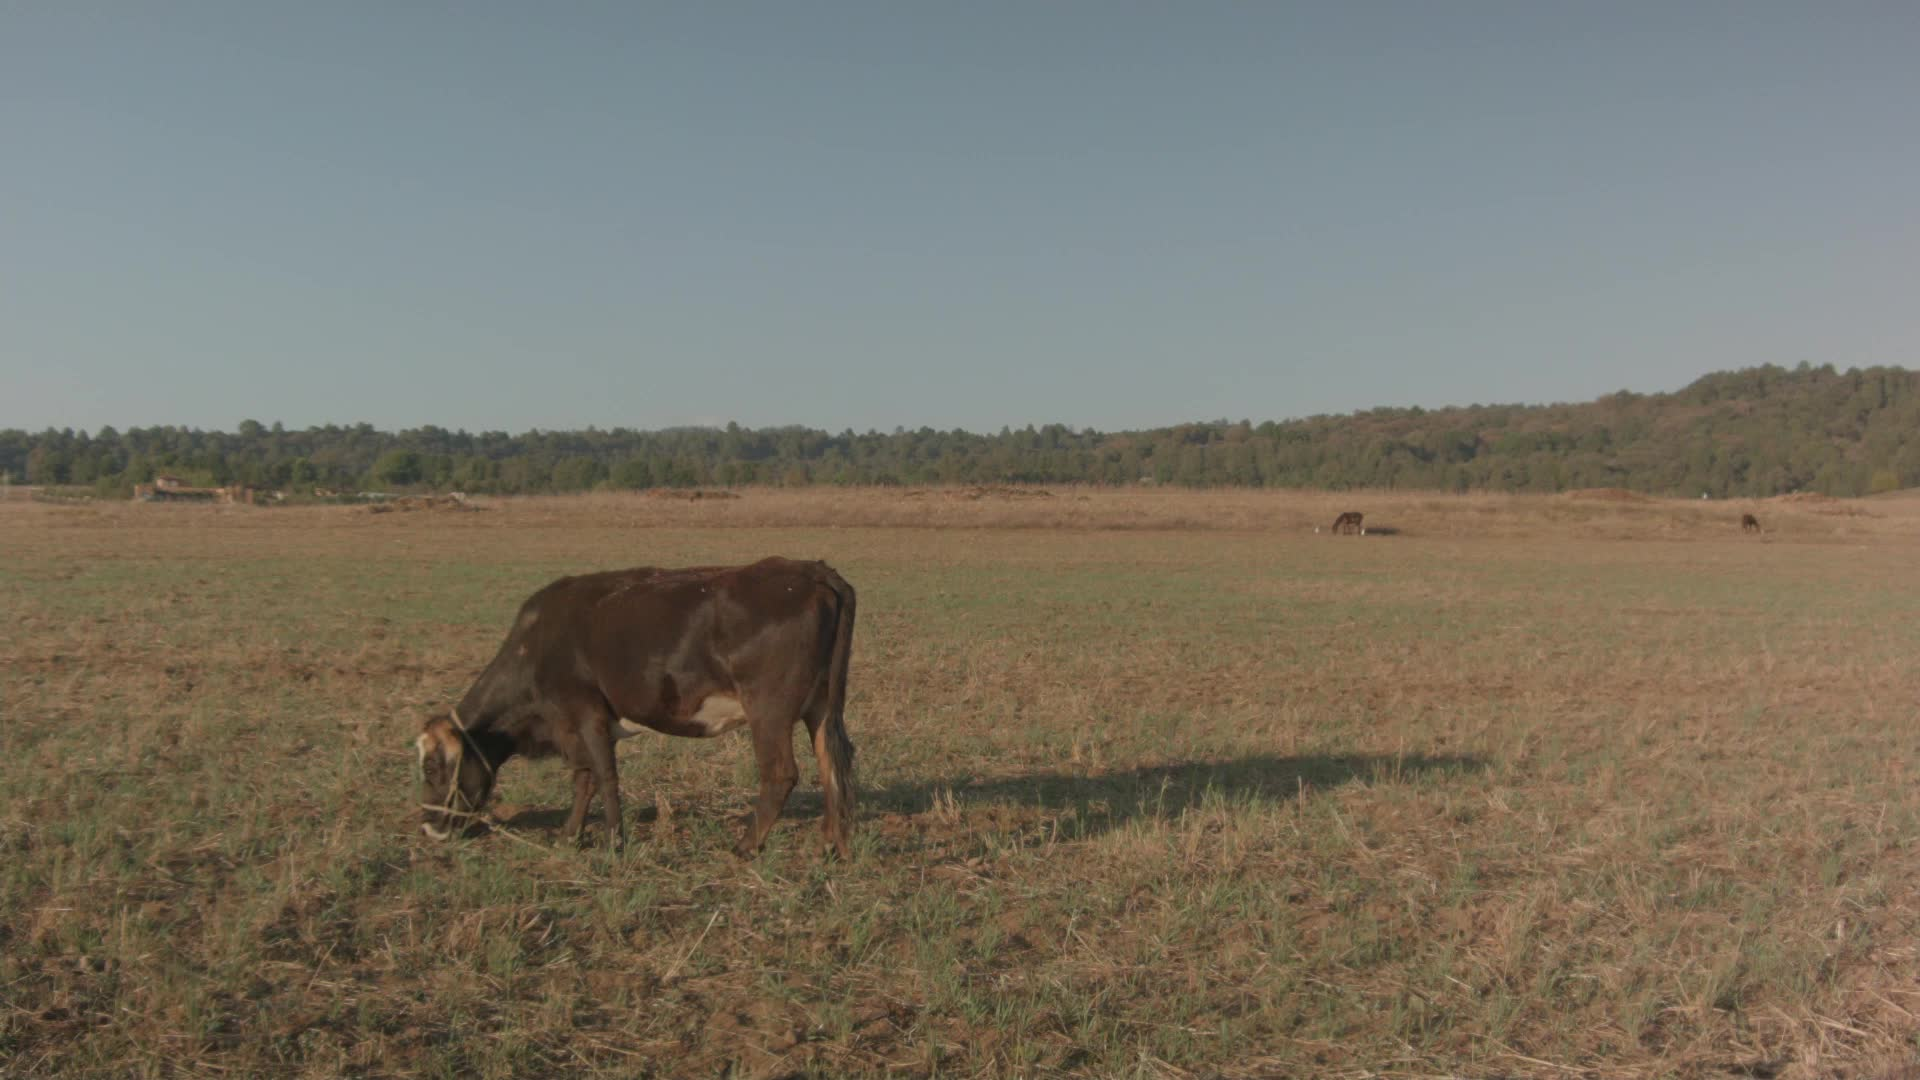

In [3]:
Image(filename=rand_img, width=500, height=500) 

In [4]:
img = skimage.io.imread(rand_img)
img.shape

(1080, 1920, 3)

In [5]:
img = kimage.load_img(rand_img, target_size=(224, 224))
x = kimage.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(x.shape)

(1, 224, 224, 3)


In [6]:
# image_top=False removes final connected layers
#base_model = VGG19(weights='imagenet')
#model = VGG16(weights='imagenet', include_top=False)

base_model = VGG16(weights='imagenet', include_top=False)
#model = Model(inputs=base_model.input, outputs=base_model.get_layer('block1_pool').output)
layer_name = 'block5_pool'

In [7]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [9]:
pred = model.predict(x)
print(pred.shape)
print(pred.ravel().shape)

(1, 7, 7, 512)
(25088,)


In [10]:
%%timeit -n5
pred = model.predict(x)

881 ms ± 121 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [11]:
fnames = glob.glob('data/StillsDERIVA/*/*.jpg')

In [12]:
idx_to_mid = {}
batch_size = len(fnames)
min_idx = 0
max_idx = min_idx + batch_size
total_max = len(fnames)
n_dims = pred.ravel().shape[0]
px = 224

# Initialize predictions matrix
preds = sp.lil_matrix((len(fnames), n_dims))

In [13]:
fnames[0].split('/')[-1]

'15_02_08_001.mp4.jpg'

In [14]:
while min_idx < total_max - 1:
    t0 = time.time()
    
    X = np.zeros(((max_idx - min_idx), px, px, 3))
    
    # For each file in batch, 
    # load as row into X
    for i in range(min_idx, max_idx):
        fname = fnames[i]
        mid = fnames[0].split('/')[-1]
        idx_to_mid[i] = mid
        img = kimage.load_img(fname, target_size=(px, px))
        img_array = kimage.img_to_array(img)
        X[i - min_idx, :, :, :] = img_array
        if i % 200 == 0 and i != 0:
            t1 = time.time()
            print('{}: {}'.format(i, (t1 - t0) / i))
            t0 = time.time()
    max_idx = i
    t1 = time.time()
    print('{}: {}'.format(i, (t1 - t0) / i))
    
    print('Preprocess input')
    t0 = time.time()
    X = preprocess_input(X)
    t1 = time.time()
    print('{}'.format(t1 - t0))
    
    print('Predicting')
    t0 = time.time()
    these_preds = model.predict(X)
    shp = ((max_idx - min_idx) + 1, n_dims)
    
    # Place predictions inside full preds matrix.
    preds[min_idx:max_idx + 1, :] = these_preds.reshape(shp)
    t1 = time.time()
    print('{}'.format(t1 - t0))
    
    min_idx = max_idx
    max_idx = np.min((max_idx + batch_size, total_max))

200: 0.06661169052124023
400: 0.03288107991218567
539: 0.017524089353203993
Preprocess input
0.2509310245513916
Predicting
588.9889993667603


In [15]:
def cosine_similarity(ratings):
    sim = ratings.dot(ratings.T)
    if not isinstance(sim, np.ndarray):
        sim = sim.toarray()
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [16]:
preds = preds.tocsr()
sim = cosine_similarity(preds)

In [17]:
def get_thumbnails(sim, idx, idx_to_mid, N=10):
    row = sim[idx, :]
    thumbs = []
    mids = []
    for x in np.argsort(-row)[:N]:
        yield(x)


def display_similars(sim, idx, idx_to_mid, N=10):
    
    for i in get_thumbnails(sim, idx, idx_to_mid, N + 1):
        if i == idx:
            print('Input Image: ')
            display(Image(filename=fnames[i],  width=300, height=300))
            print('Similar Images: ')
        else:
            display(Image(filename=fnames[i],  width=300, height=300))
    

Input Image: 


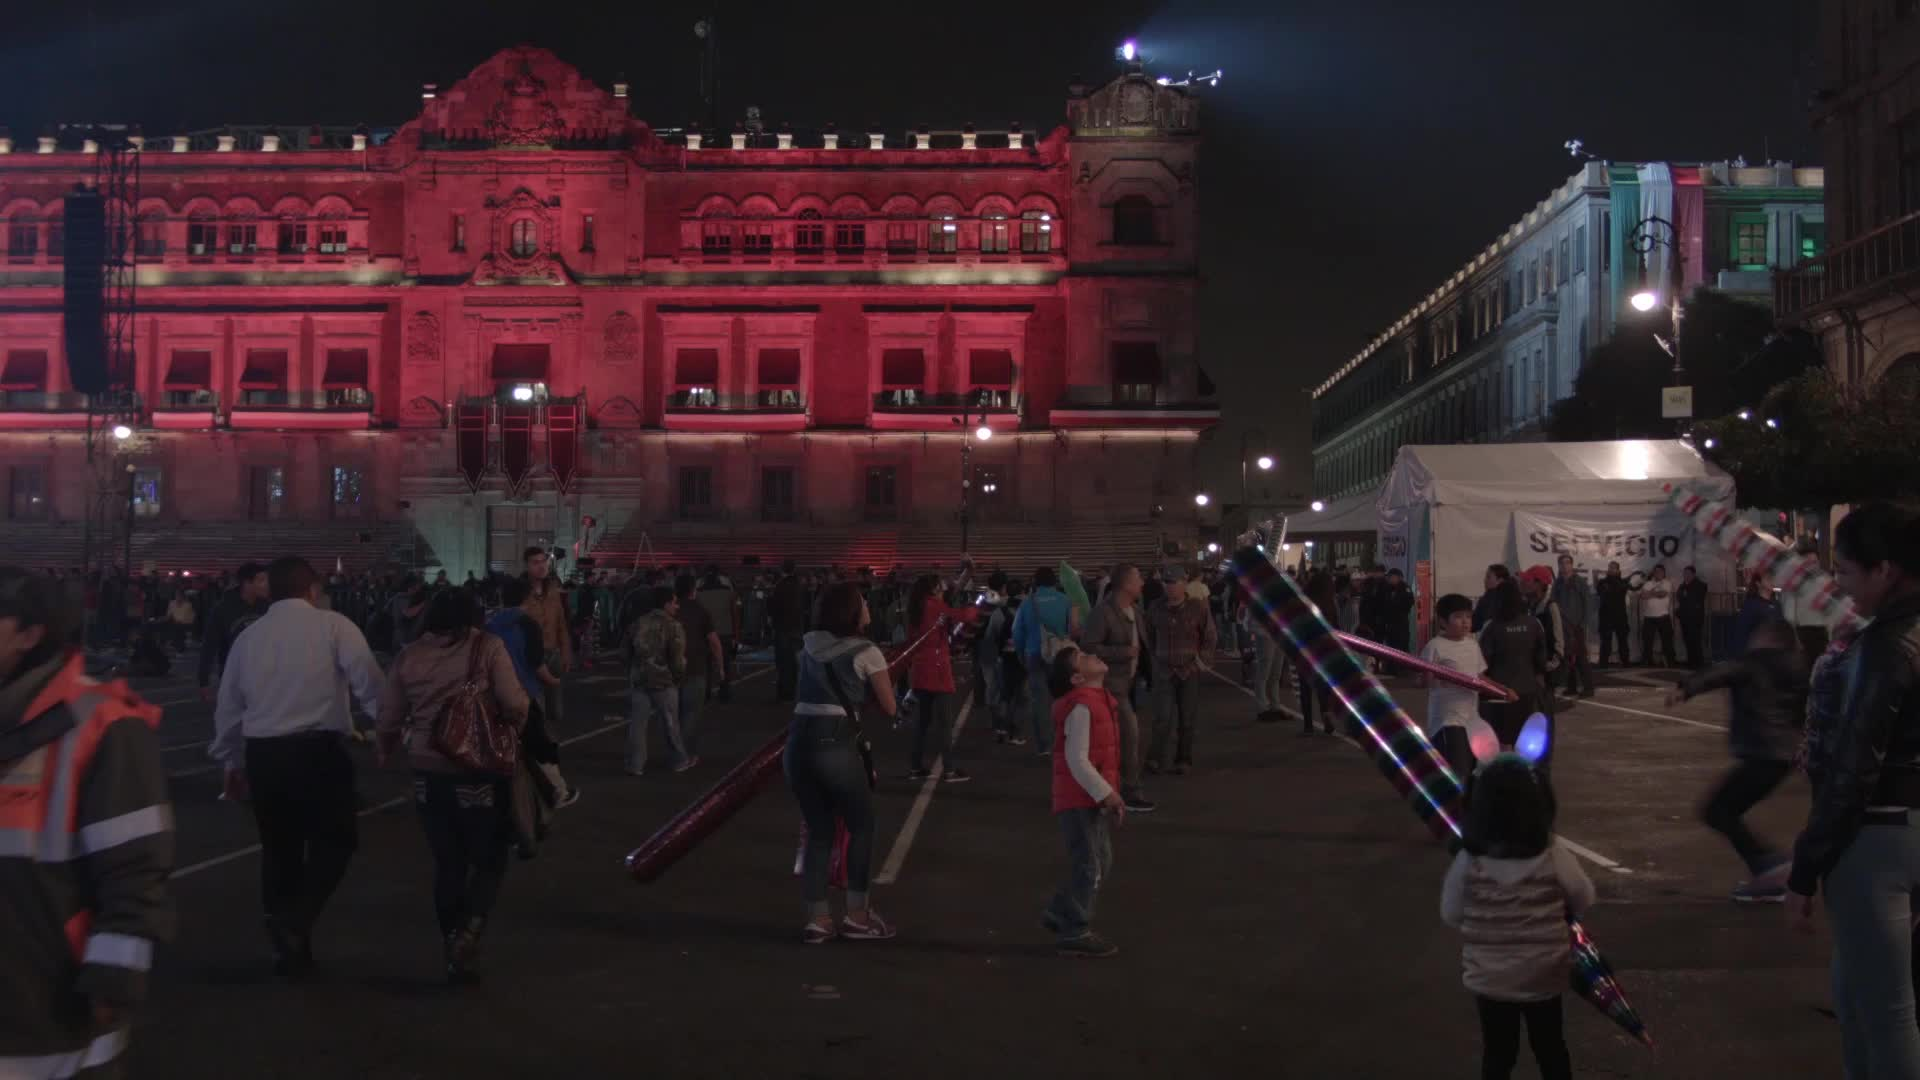

Similar Images: 


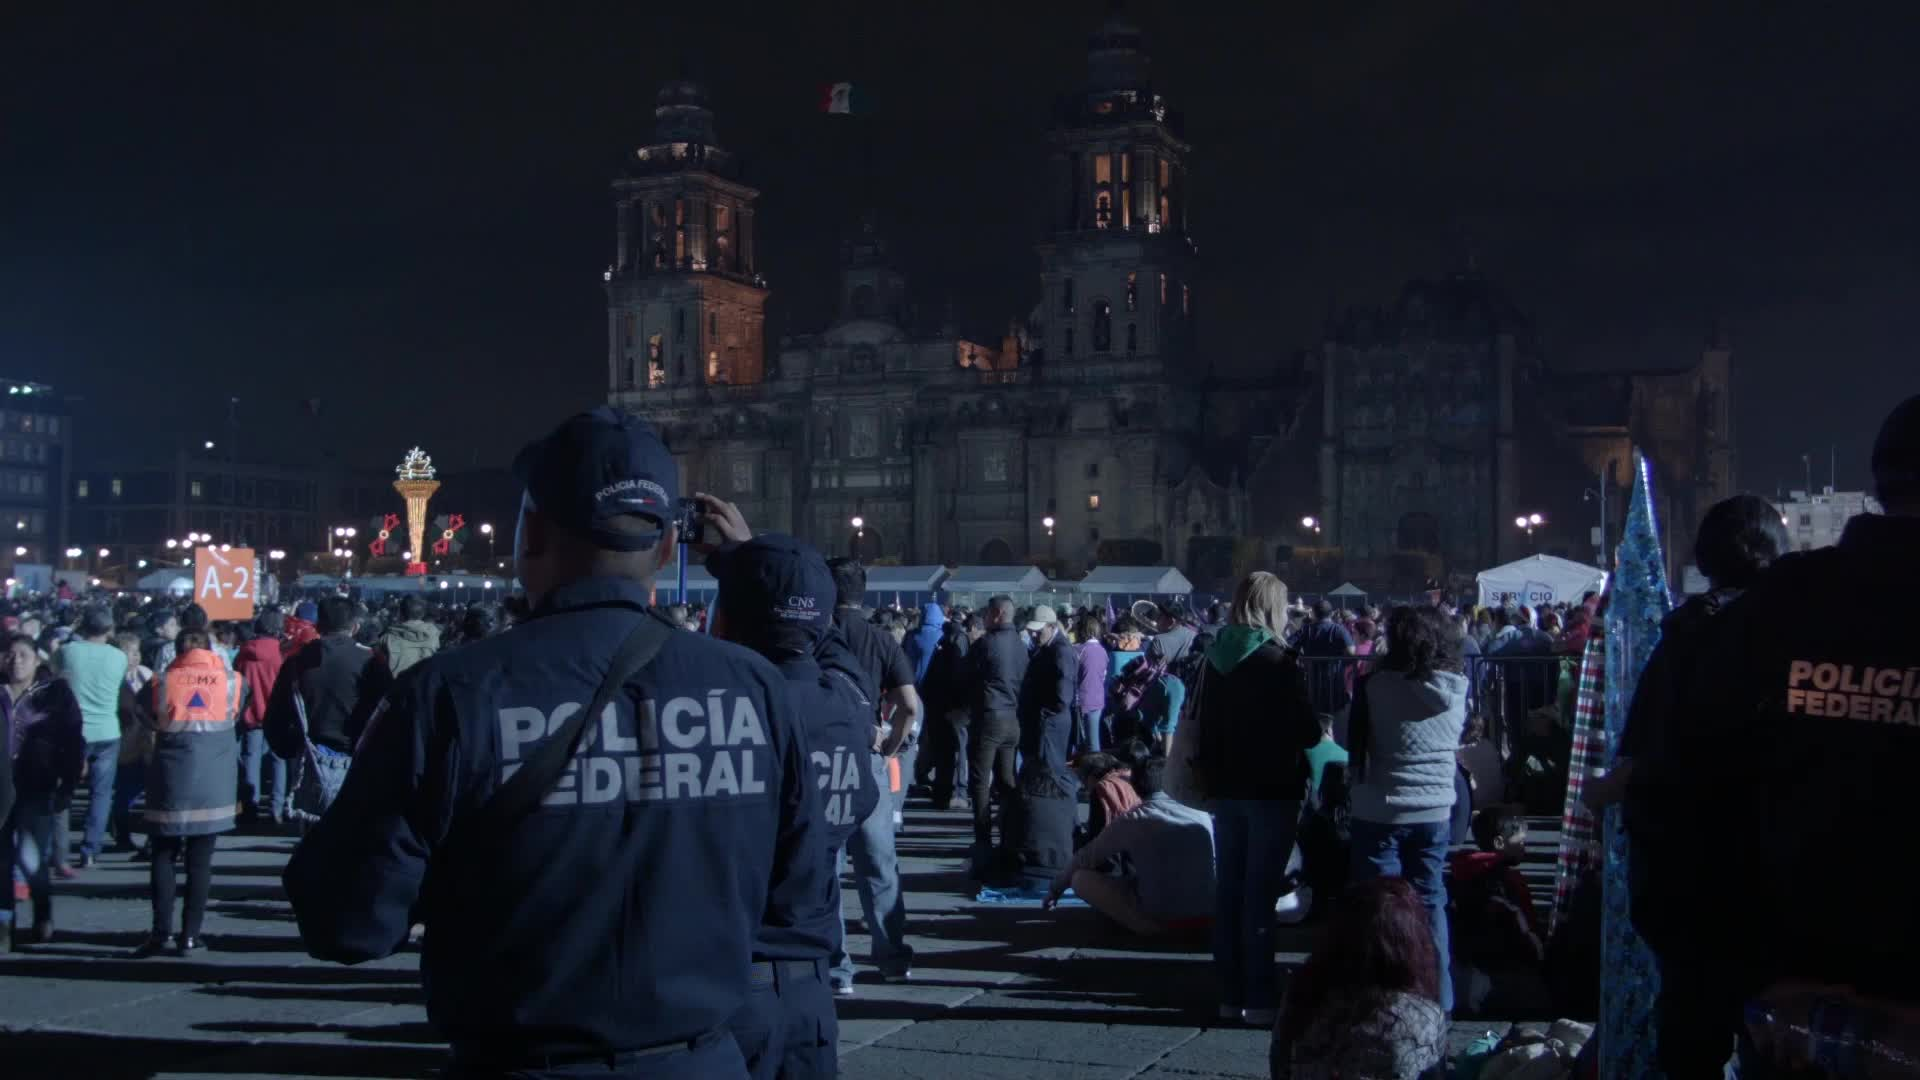

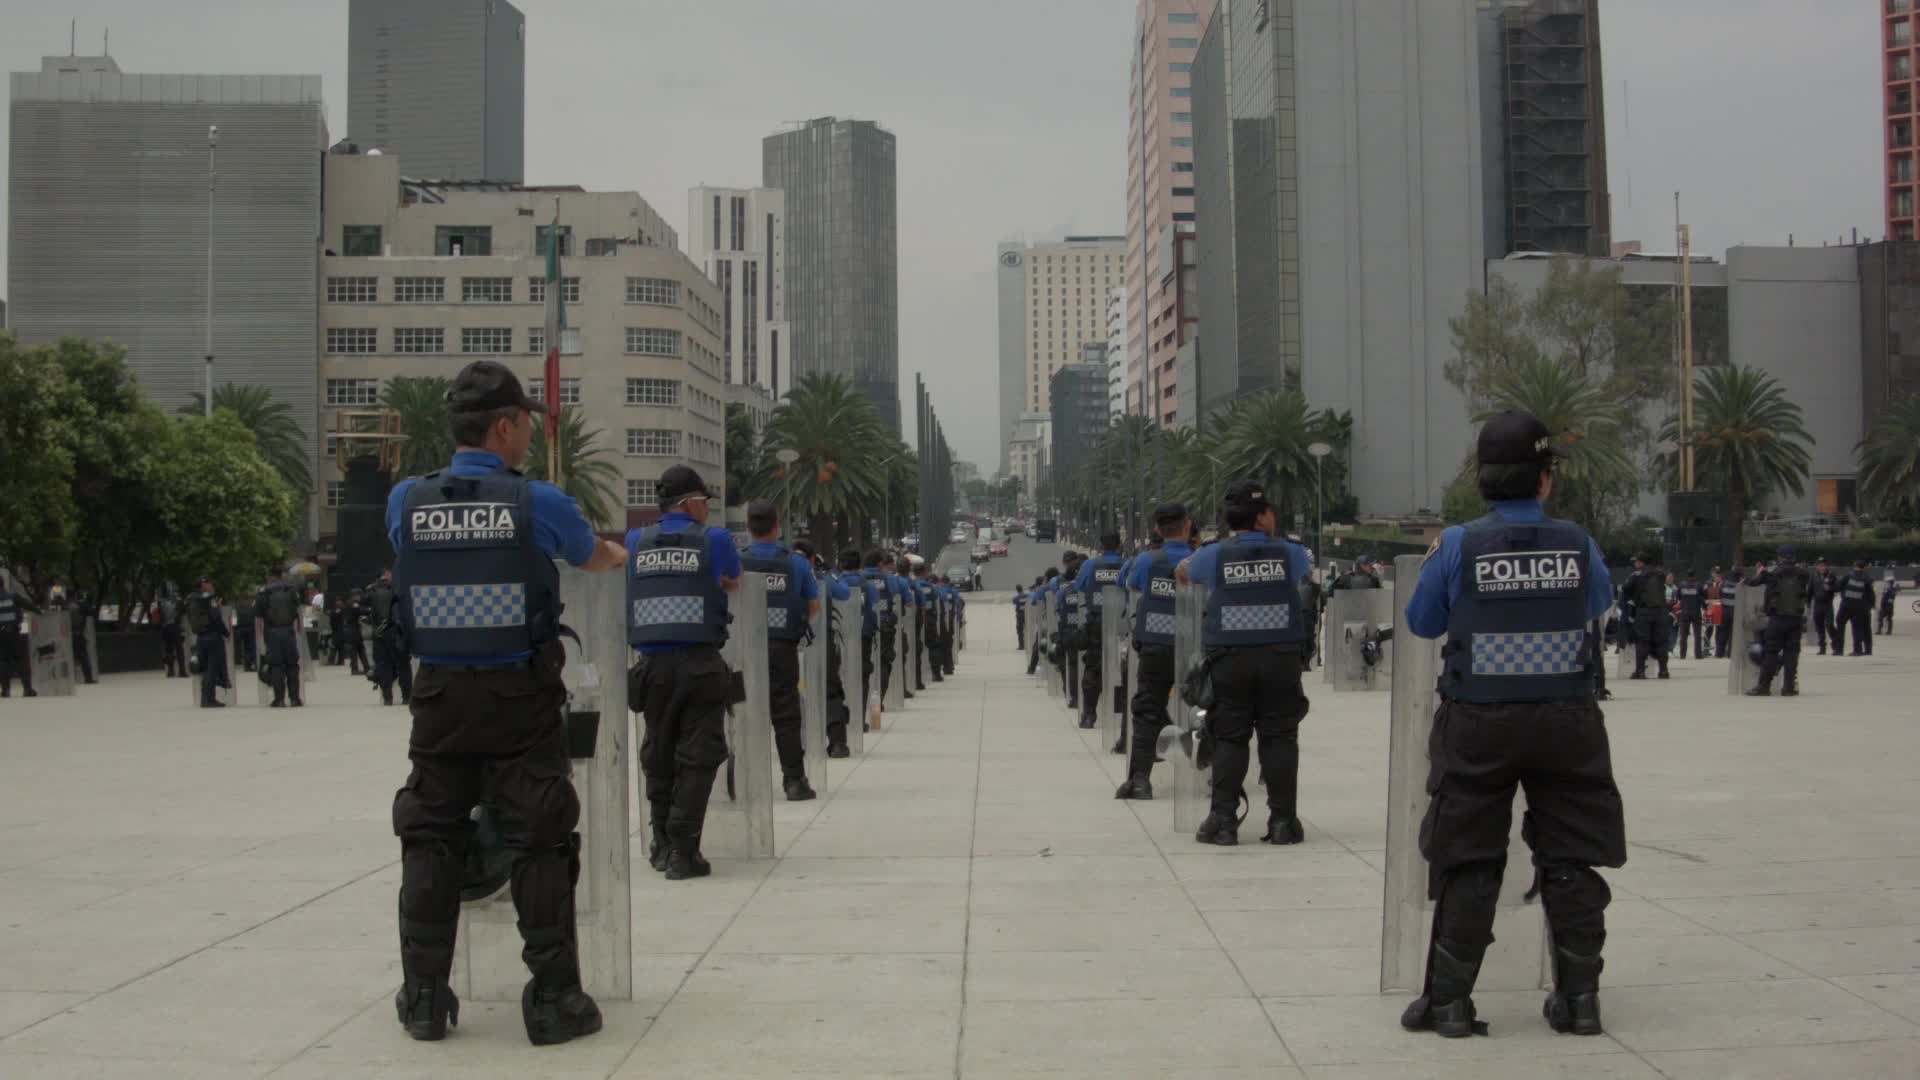

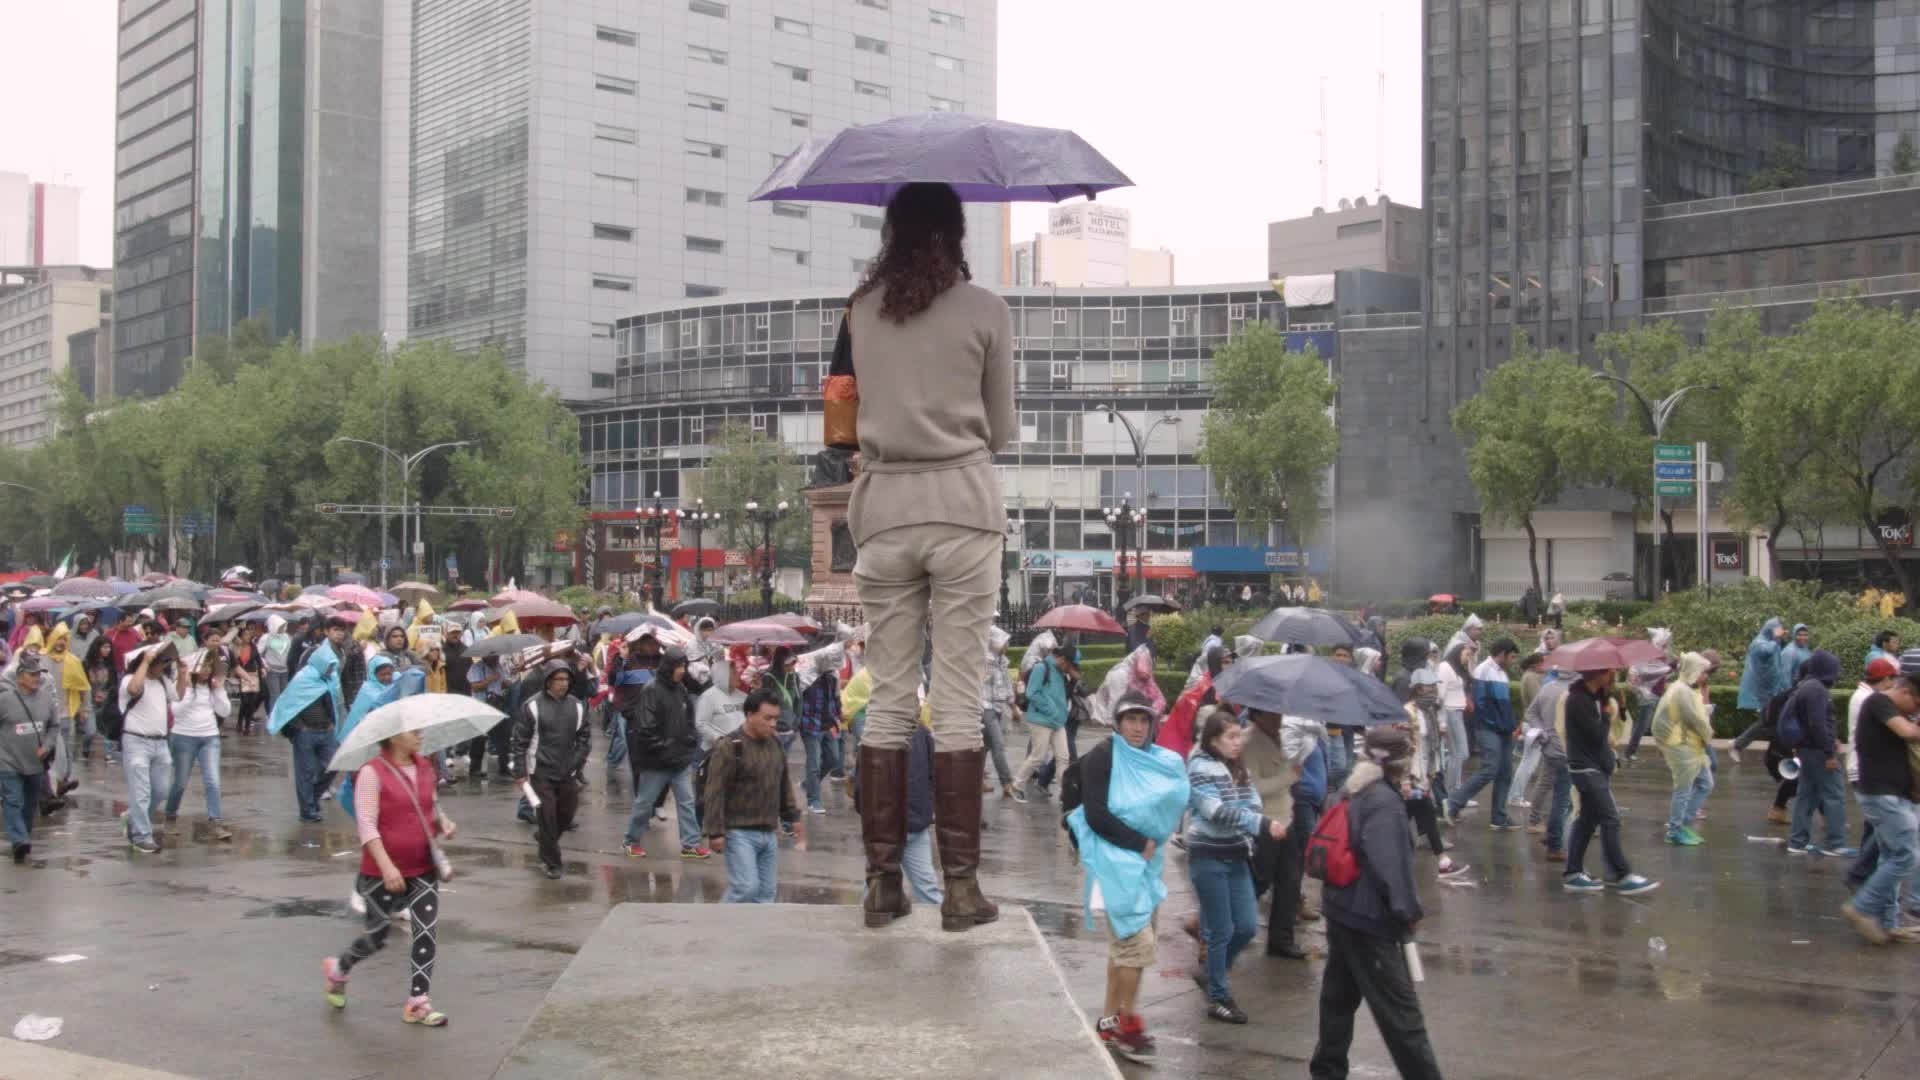

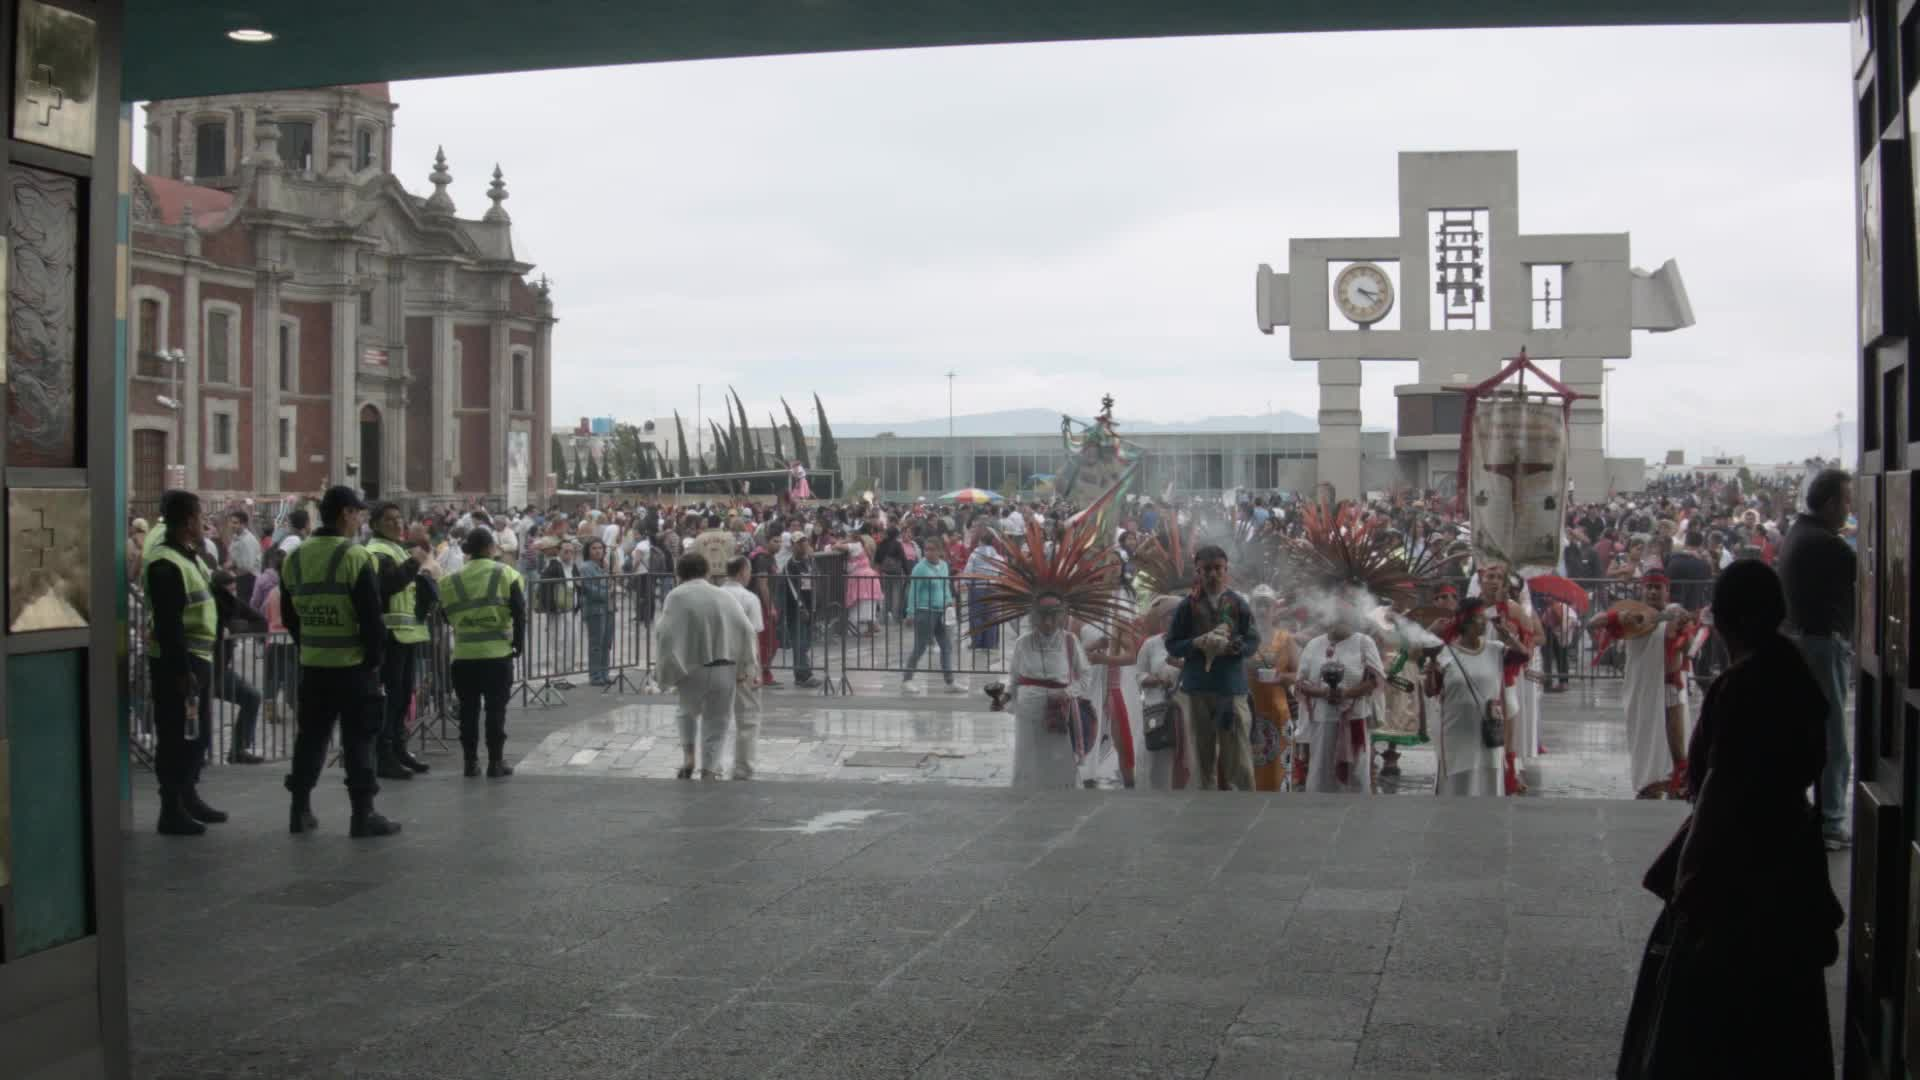

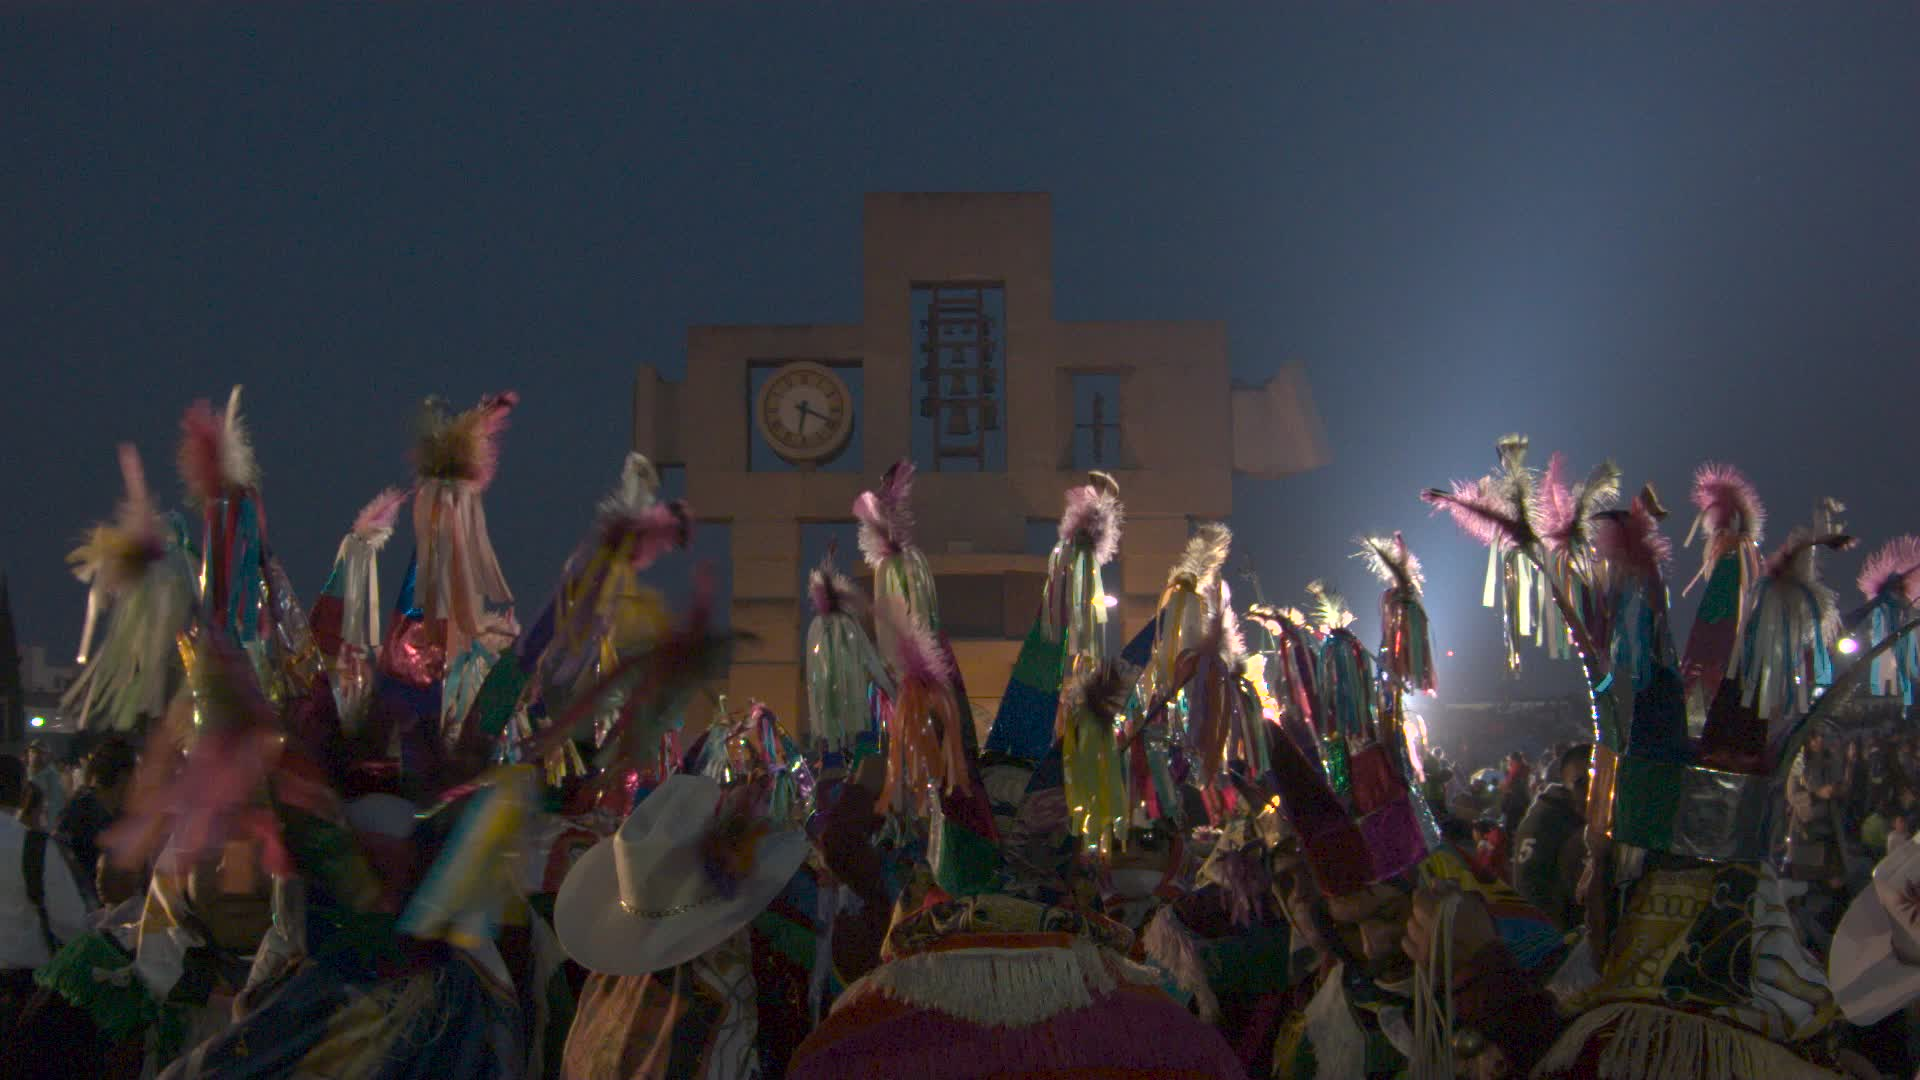

In [26]:
display_similars(sim, 423, idx_to_mid, N=5)

In [24]:
np.save('output/{}_sims'.format(layer_name), sim)
pickle.dump( idx_to_mid, open( "output/{}_idx_to_mid.p".format(layer_name), "wb" ) )